In [1]:
import pickle
import numpy as np
import pandas as pd
import xgboost as xgb
from time import time
from feature_generators.test_features import CountFeatureGenerator, TfidfFeatureGenerator, SvdFeatureGenerator, Word2VecFeatureGenerator, SentimentFeatureGenerator
from feature_generators.helpers import *
import feature_generators.ngram as ngram


In [2]:
# Load the saved booster model
with open('feature_generators/xgb_model.pkl', 'rb') as mod:
    xgb_mod = pickle.load(mod)

In [3]:
def process(data):
    """
    Preprocesses the data provided and generates
    unigrams, bigrams and trigrams.
    Saves the features in the separate columns in the dataframe.
    
    Input: Dataframe
    
    Returns Dataframe
    """
    
    print (data.iloc[1])
    print ('>>> Data shape: ', data.shape)
    
    t0 = time()
    print("---Generating n-grams Features!---")
    print ("Generating unigram")
    data["Headline_unigram"] = data["Headline"].map(lambda x: preprocess_data(x))
    data["articleBody_unigram"] = data["articleBody"].map(lambda x: preprocess_data(x))
    
    print ("Generating bigram")
    join_str = "_"
    data["Headline_bigram"] = data["Headline_unigram"].map(lambda x: ngram.getBigram(x, join_str))
    data["articleBody_bigram"] = data["articleBody_unigram"].map(lambda x: ngram.getBigram(x, join_str))

    print ("Generating trigram")
    join_str = "_"
    data["Headline_trigram"] = data["Headline_unigram"].map(lambda x: ngram.getTrigram(x, join_str))
    data["articleBody_trigram"] = data["articleBody_unigram"].map(lambda x: ngram.getTrigram(x, join_str))

    print("---n-gram Features generated---")
    print("Time taken: {} seconds\n".format(time() - t0))
    
    return data


In [4]:
def build_test_data(data):
    """
    Generates various features needed to predict
    the class of the news.
    
    Input: DataFrame
    Returns Array of generated features.
    """

    data = process(data)
    
    generators = [CountFeatureGenerator,
                  TfidfFeatureGenerator,
                  SvdFeatureGenerator,
                  Word2VecFeatureGenerator,
                  SentimentFeatureGenerator
                 ]
    
    # Class generators one by one to generate features
    features = [feature for generator in generators for feature in generator(data)]
    print("Total number of raw features: {}".format(len(features)))
    
    # Stack and return the features
    return np.hstack(features)

In [5]:
def check(news):
    """
    Predicts the probable class and corresponding probabilites
    of the news belonging to a certian clas
    
    Input: DataFrame of news: Headline and Article body only
    Returns DataFrame with class predictions
    """

    test_x = build_test_data(data)
    
    # Save feature_vector for quick debugging
    with open('tmp/feature_vector', 'wb') as fv:
        pickle.dump(test_x, fv)

    dtest = xgb.DMatrix(test_x)
    print("Total Feature count in the test set: ", len(dtest.feature_names))
    
    # Use Booster to predict class
    pred_prob_y = xgb_mod.predict(dtest).reshape(test_x.shape[0], 4) # predicted probabilities
    pred_y = np.argmax(pred_prob_y, axis=1)

    LABELS = ['agree', 'disagree', 'discuss', 'unrelated']
    predicted = [LABELS[int(a)] for a in pred_y]
    # print (predicted)

    df_output = pd.DataFrame()
    df_output['Headline'] = data['Headline']
    df_output['Body'] = data['articleBody']
    df_output['Stance'] = predicted
    df_output['argree_prob'] = pred_prob_y[:, 0]
    df_output['disagree_prob'] = pred_prob_y[:, 1]
    df_output['discuss_prob'] = pred_prob_y[:, 2]
    df_output['unrelated_prob'] = pred_prob_y[:, 3]
    return df_output


In [6]:
data = pd.read_csv("../Datasets/LittleSplits/clickbait_little.csv")
data.drop(columns=['type', 'authors'], inplace=True)
data.columns = ['articleBody', 'Headline']

df_output = check(data)
df_output

articleBody    Sarah Huckabee Sanders is a well-paid liar. Da...
Headline       Sarah Huckabee Blinks Strangely, Curls Lip, & ...
Name: 1, dtype: object
>>> Data shape:  (100, 2)
---Generating n-grams Features!---
Generating unigram
Generating bigram
Generating trigram
---n-gram Features generated---
Time taken: 0.5331783294677734 seconds


---Generating Counting Features:---
generate counting features
xBasicCounts.shape: (100, 41)
---Counting Features is complete---
Time taken 0.1792283058166504 seconds


---Generating TFIDF Features:---
xHeadlineTfidf.shape: (100, 769582)
xBodyTfidf.shape: (100, 769582)
simTfidf.shape: (100, 1)
---TFIDF Features is complete---
Time taken 0.7912337779998779 seconds


---Generating SVD Features:---
xHeadlineSvd.shape: (100, 50)
xBodySvd.shape: (100, 50)
simSvd.shape: (100, 1)
---SVD Features is complete---
Time taken 21.264615297317505 seconds


---Generating Word2Vector Features:---
GloVe model loaded!
headlineVec.shape (100, 50)
bodyVec.shape (100, 5

,Headline,Body,Stance,argree_prob,disagree_prob,discuss_prob,unrelated_prob
0,Email Protection,The website from which you got to this page is...,discuss,7.685383e-02,6.387644e-05,0.922833,0.000249
1,"Sarah Huckabee Blinks Strangely, Curls Lip, & ...",Sarah Huckabee Sanders is a well-paid liar. Da...,unrelated,3.265119e-02,1.422451e-03,0.407382,0.558545
2,JUST IN: Top Trump Appointee Resigns Without A...,Brian Neale is the Center for Medicare & Medic...,unrelated,1.009284e-02,1.138833e-03,0.127745,0.861023
3,Egypt’s race for president kicks off with arre...,Egypt’s presidential campaign has kicked into ...,discuss,1.223063e-01,9.515501e-04,0.876680,0.000062
4,Ted Lieu Just Made Trump Look Like An Fool On ...,As the president spends the weekend pouting ov...,discuss,8.188941e-03,3.530963e-04,0.973426,0.018032
5,Trump Tweets Desperate 4AM Nonsense During Wed...,Tuesday brought bombshell after bombshell in r...,unrelated,3.274504e-04,7.163137e-05,0.162393,0.837208
6,Mueller Announces New Trump Cabinet Interview ...,Tuesday brought an endless stream of new revel...,discuss,3.813165e-03,1.658181e-04,0.934551,0.061470
7,"""Too Big To Believe"" - Massive Scandal Is Brew...",s the Potemkin Village walls of The Left's 'Tr...,discuss,7.728573e-02,1.143288e-03,0.919589,0.001982
8,BREAKING: New Trump Weird Spanking Sex Details...,No one really wants to hear about Trump’s pref...,discuss,3.665329e-02,8.796269e-04,0.962353,0.000114
9,JUST IN: Official 2018 Polls Released; America...,As Republicans continue to blast Democrats in ...,discuss,1.304049e-02,3.877570e-04,0.896221,0.090350


In [7]:
%matplotlib inline

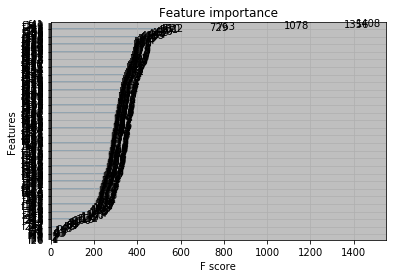

In [8]:
# Visualize the importance of each feature in the model.
xgb.plot_importance(xgb_mod)

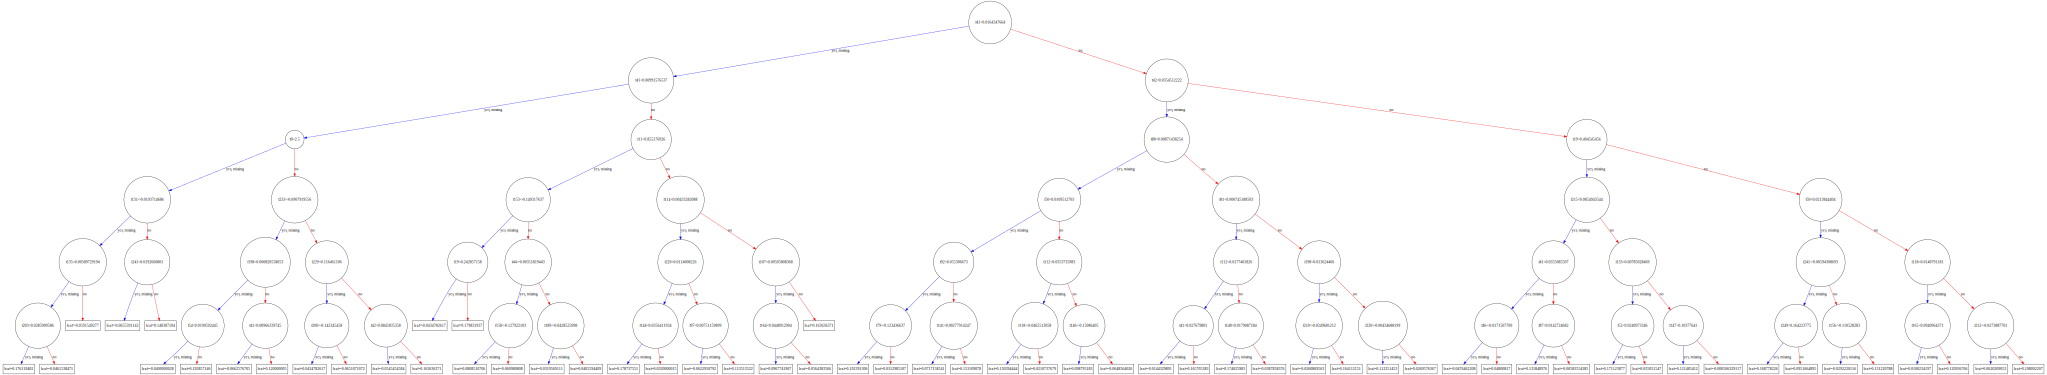

In [9]:
# Make deciscion tree
xgb.to_graphviz(xgb_mod, num_trees=2)

## For quick debugging.

In [10]:
import pickle
import xgboost as xgb

with open('model/xgb_model.pkl', 'rb') as mod:
    xgb_mod = pickle.load(mod)

with open('tmp/feature_vector', 'rb') as fv:
    test_x = pickle.load(fv)

dtest = xgb.DMatrix(test_x)

print("Total Feature count in the test set: ", len(dtest.feature_names))

pred_prob_y = xgb_mod.predict(dtest).reshape(test_x.shape[0], 4)
pred_y = np.argmax(pred_prob_y, axis=1)

LABELS = ['agree', 'disagree', 'discuss', 'unrelated']
predicted = [LABELS[int(a)] for a in pred_y]
# print (predicted)

df_output = pd.DataFrame()
df_output['Headline'] = data['Headline']
df_output['Body'] = data['articleBody']
df_output['Stance'] = predicted
df_output['argree_prob'] = pred_prob_y[:, 0]
df_output['disagree_prob'] = pred_prob_y[:, 1]
df_output['discuss_prob'] = pred_prob_y[:, 2]
df_output['unrelated_prob'] = pred_prob_y[:, 3]
df_output

Total Feature count in the test set:  252


,Headline,Body,Stance,argree_prob,disagree_prob,discuss_prob,unrelated_prob
0,Email Protection,The website from which you got to this page is...,discuss,7.685383e-02,6.387644e-05,0.922833,0.000249
1,"Sarah Huckabee Blinks Strangely, Curls Lip, & ...",Sarah Huckabee Sanders is a well-paid liar. Da...,unrelated,3.265119e-02,1.422451e-03,0.407382,0.558545
2,JUST IN: Top Trump Appointee Resigns Without A...,Brian Neale is the Center for Medicare & Medic...,unrelated,1.009284e-02,1.138833e-03,0.127745,0.861023
3,Egypt’s race for president kicks off with arre...,Egypt’s presidential campaign has kicked into ...,discuss,1.223063e-01,9.515501e-04,0.876680,0.000062
4,Ted Lieu Just Made Trump Look Like An Fool On ...,As the president spends the weekend pouting ov...,discuss,8.188941e-03,3.530963e-04,0.973426,0.018032
5,Trump Tweets Desperate 4AM Nonsense During Wed...,Tuesday brought bombshell after bombshell in r...,unrelated,3.274504e-04,7.163137e-05,0.162393,0.837208
6,Mueller Announces New Trump Cabinet Interview ...,Tuesday brought an endless stream of new revel...,discuss,3.813165e-03,1.658181e-04,0.934551,0.061470
7,"""Too Big To Believe"" - Massive Scandal Is Brew...",s the Potemkin Village walls of The Left's 'Tr...,discuss,7.728573e-02,1.143288e-03,0.919589,0.001982
8,BREAKING: New Trump Weird Spanking Sex Details...,No one really wants to hear about Trump’s pref...,discuss,3.665329e-02,8.796269e-04,0.962353,0.000114
9,JUST IN: Official 2018 Polls Released; America...,As Republicans continue to blast Democrats in ...,discuss,1.304049e-02,3.877570e-04,0.896221,0.090350
